# Imports

In [ ]:
import yfinance as yf, numpy as np, pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

# Recoleccion de datos

In [ ]:
smas = ((30, 100), (50, 200), (70, 300))
ventana = 250  # Es la ventana a partir de que rueda quiero predecir si el rendimiento va a estar por encima o debajo de algun umbral

# Me baso en un set inicial de tickers (100% arbitrario, para partir de algo)
tickers = ['LMT', 'SO', 'BAC', 'ABT', 'IBM', 'MCD', 'TMO', 'WFC', 'COST', 'TSLA', 'NFLX', 'BA', 'AMAT', 'UNH',
           'EXC', 'T', 'C', 'GD', 'SPG', 'INTU', 'AXP', 'GE', 'HD', 'CVX', 'DHR', 'LUV', 'TXN', 'LLY', 'SBUX',
           'CVS', 'TGT', 'PEP', 'GOOGL', 'HON', 'JPM', 'QCOM', 'CMCSA', 'VZ', 'FDX', 'PG', 'NEM', 'AAPL', 'LOW',
           'DIS', 'SLB', 'PM', 'CSX', 'KO', 'GS', 'MET', 'NSC', 'AMGN', 'MMM', 'META', 'JNJ', 'AMZN', 'INTC', 'V',
           'NEE', 'WMT', 'CSCO', 'GM', 'COP', 'CAT', 'ADBE', 'ORCL', 'CME', 'PFE', 'OXY', 'MA', 'MSFT', 'UPS',
           'ADP', 'MS', 'CRM', 'UNP', 'MO', 'EMR', 'NVDA', 'GILD', 'BMY', 'ABBV', 'NKE', 'XOM', 'MRK', 'MDLZ']

df = yf.download(tickers, start='2000-01-01',auto_adjust=True)
spy = yf.download('SPY', start='2000-01-01', auto_adjust=True)
vix = yf.download('^VIX', start='2000-01-01', auto_adjust=True)

dfs_train, dfs_test = [], []
for ticker in tickers:
    data = df['Close'][ticker].to_frame()
    data.columns = ['Close']
    dif = data['Close'].diff()
    RSI_CONS = 50
    win = pd.DataFrame(np.where(dif > 0, dif, 0))
    loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
    ema_win = win.ewm(alpha=1/RSI_CONS).mean()
    ema_loss = loss.ewm(alpha=1/RSI_CONS).mean()
    rs = ema_win / ema_loss
    rsi = 100 - (100 / (1 + rs))
    rsi.index = data.index

    data['pctChange'] = data['Close'].pct_change()
    data['fw'] = data['Close'].shift(-ventana)/data['Close']-1
    data[f'RSI_{RSI_CONS}'] = rsi/100
    v = data['pctChange'].rolling(50).std() * 50**0.5
    data['volatilidad_zs'] = (v - v.rolling(50).mean()) / v.rolling(50).std()
    data['volatilidad_vix'] = v / vix.Close
    data['vix'] = vix.Close

    spy_zs_slow = (spy.Close - spy.Close.rolling(80).mean()) / spy.Close.rolling(80).std()
    spy_zs_fast = (spy.Close - spy.Close.rolling(40).mean()) / spy.Close.rolling(40).std()

    data['SP500_Zscore_fast'] = spy_zs_fast
    data['SP500_Zscore_slow'] = spy_zs_slow
    data['SP500_rel'] = spy_zs_slow / spy_zs_fast

    data['sma_volatilidad'] = data['pctChange'].rolling(50).std() * 50**0.5
    data['ema_volatilidad'] = data['pctChange'].ewm(span=40).std() * 40**0.5
    data['SPY_Corr'] = data.Close.pct_change().rolling(40).corr(spy.Close.pct_change())
    c1 = f'cruce_{smas[0][0]}_{smas[0][1]}'
    c2 = f'cruce_{smas[1][0]}_{smas[1][1]}'
    c3 = f'cruce_{smas[2][0]}_{smas[2][1]}'
    data[c1] = data['Close'].rolling(smas[0][0]).mean()/data['Close'].rolling(smas[0][1]).mean()-1
    data[c2] = data['Close'].rolling(smas[1][0]).mean()/data['Close'].rolling(smas[1][1]).mean()-1
    data[c3] = data['Close'].rolling(smas[2][0]).mean()/data['Close'].rolling(smas[2][1]).mean()-1
    # Uso el 85% de la serie para entrenar y solo el 15% para validar (asi es mas robusto)
    qtrain = int(len(data)*0.85)
    dfs_train.append(data.reset_index(drop=True).iloc[:qtrain])
    dfs_test.append(data.reset_index(drop=True).iloc[qtrain:])

data_train = pd.concat(dfs_train).reset_index(drop=True)
data_test = pd.concat(dfs_test).reset_index(drop=True)
len(data_train.dropna()), len(data_test.dropna())

[*********************100%%**********************]  86 of 86 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(388342, 55384)

# Matriz de Diseño

In [ ]:
data_train.fw.median()

0.12438885200408634

In [ ]:
data_train['target'] = 0
data_train.loc[data_train.fw >= 0.14 , 'target'] = 1
data_train.dropna(inplace=True)

data_test['target'] = 0
data_test.loc[data_test.fw >= 0.14 , 'target'] = 1

data_test_full = data_test.copy()
data_test.dropna(inplace=True)

features = 13

X_train, X_test = data_train.iloc[:,-(features+1):-1], data_test.iloc[:,-(features+1):-1]
y_train, y_test = data_train.iloc[:,-1], data_test.iloc[:,-1]

In [ ]:
y_train.to_frame().groupby('target').size()

target
0    203120
1    185222
dtype: int64

In [ ]:
y_test.to_frame().groupby('target').size()

target
0    29671
1    25713
dtype: int64

# Fit y test

CPU times: user 12.1 s, sys: 28.2 ms, total: 12.1 s
Wall time: 12.2 s


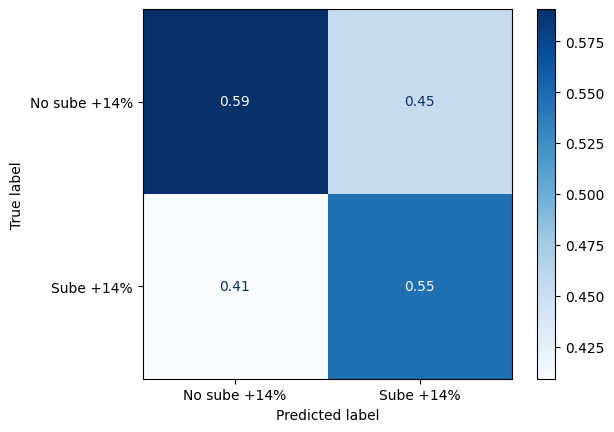

In [ ]:
%%time

# Pedimos que cada nodo tenga al menos 30 datos
levels = int(math.log((len(X_train)/30),2))

modelo = DecisionTreeClassifier(criterion = 'entropy', max_depth=levels, random_state=1)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

disp = ConfusionMatrixDisplay.from_estimator(modelo, X_test.dropna(), y_test.dropna(), normalize='pred',
                                             display_labels=['No sube +14%','Sube +14%'], cmap='Blues')


m = disp.confusion_matrix

## Analizamos target -14%

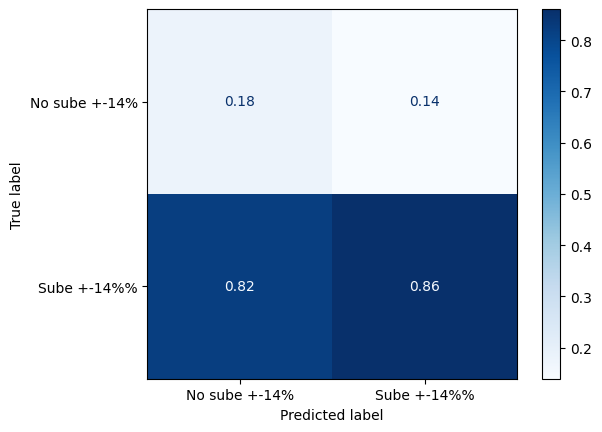

In [ ]:
# ejemplo que pasa en la simetrica para abajo?
NUEVO_TARGET = -0.14

data_test_alt = data_test.copy()
data_test_alt['target'] = 0
data_test_alt.loc[data_test_alt.fw >= NUEVO_TARGET , 'target'] = 1
y_test_alt =  data_test_alt.iloc[:,-1]

# Como el modelo entrenado es el mismo, solo evaluo con el criterio diferente del target

disp = ConfusionMatrixDisplay.from_estimator(modelo, X_test.dropna(), y_test_alt.dropna(), normalize='pred',
                                             display_labels=[f'No sube +{NUEVO_TARGET:.0%}',
                                                            f'Sube +{NUEVO_TARGET:.0%}%'],
                                             cmap='Blues')


m = disp.confusion_matrix

# Proxy de cálculo Esperanza matematica

In [ ]:
data_test.fw.median()

0.11218605018745142

In [ ]:
# media de trades ganadores y perdedores (arriba de +14%, abajo de -14%)
w_mean = math.log(data_test.loc[data_test.fw>0.14].fw.mean() +1)
l_mean = math.log(data_test.loc[data_test.fw<-0.14].fw.mean() +1)

w_mean, l_mean

(0.38925072270840827, -0.3200182437690496)

In [ ]:
# Calculo % de trades positivos (arriba de +11%) y negativos (abajo de -11%)

# Uso una funcion para recalcular los y de validacion en funcion del target
def getTestAlt(TARGET):
    data_test_alt = data_test.copy()
    data_test_alt['target'] = 0
    data_test_alt.loc[data_test_alt.fw >= TARGET , 'target'] = 1
    y_test_alt =  data_test_alt.iloc[:,-1]
    return y_test_alt

# Uso la matriz de confusion para calcular la probabilidad de acertar o fallar
m_arriba_11 = np.array(confusion_matrix(getTestAlt(0.14), y_pred, normalize='pred'))
win_q = m_arriba_11[1][1]

m_abajo_11 = np.array(confusion_matrix(getTestAlt(-0.14), y_pred, normalize='pred'))
loss_q = m_abajo_11[0][1]

win_q, loss_q

(0.5468279303988131, 0.13947214603659908)

In [ ]:
# normalizo las probabilidades al 100%
# estoy descartando todos los trades entre -11% y 11% porque asumo que se compensan

win_perc, loss_perc = win_q/(win_q+loss_q), loss_q/(win_q+loss_q)
win_perc, loss_perc

(0.7967767295597484, 0.20322327044025157)

In [ ]:
# Esperanza matematica

E = math.e** (w_mean * win_perc + l_mean * loss_perc) - 1
E

0.2777628351307184